<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/GENOME_AI_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.nature.com/articles/s41586-025-10014-0?utm_source=linkedin&utm_medium=social&utm_campaign=&utm_content=

In [24]:
!nvidia-smi

Thu Jan 29 08:19:13 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   63C    P0             32W /   72W |    5959MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!apt-get update && apt-get install -y graphviz
!pip install ipywidgets
!pip install --upgrade setuptools wheel

In [ ]:
!pip cache purge
!pip install nemo_toolkit[all] -q
!pip install --no-build-isolation transformer-engine[pytorch] -q
!pip install nemo_run opendatasets pandas bitsandbytes accelerate -q
!pip install --upgrade transformers -q

In [ ]:
!pip install "numpy<2.0" --force-reinstall

In [ ]:
from pathlib import Path

import nemo_run as run
from nemo import lightning as nl
from nemo.collections import llm
from nemo.collections.llm.recipes.precision.mixed_precision import bf16_mixed

In [2]:
from huggingface_hub import login

from google.colab import userdata

# Login to Hugging Face
login(token=userdata.get("HF_TOKEN"))

In [6]:
import os
import nemo_run as run
from nemo.collections import llm
import nemo as ne
from nemo import lightning as nl
import transformer_engine as te

print(f"Nemo version: {ne.__version__}")
print(f"NeMo RUN version: {run.__version__}")
print(f"Transformer Engine version: {te.__version__}")

Nemo version: 2.6.1
NeMo RUN version: 0.7.0
Transformer Engine version: 2.11.0


In [7]:
import sys
import os
import inspect

print("--- Python System Paths (sys.path) ---")
for p in sys.path:
    print(p)

print("\n--- Inspecting nemo package ---")
try:
    import nemo
    print(f"Nemo package found at: {os.path.dirname(inspect.getfile(nemo))}")
    nemo_path = os.path.dirname(inspect.getfile(nemo))
    print("Contents of nemo directory:")
    for item in os.listdir(nemo_path):
        print(item)

    print("\n--- Attempting direct import of nemo.collections ---")
    try:
        import nemo.collections
        print("Successfully imported nemo.collections")
        print(f"nemo.collections path: {os.path.dirname(inspect.getfile(nemo.collections))}")
    except ModuleNotFoundError as e:
        print(f"Failed to import nemo.collections: {e}")
        print("This indicates the 'collections' submodule is not found within the nemo package structure.")

except ModuleNotFoundError:
    print("Nemo package not found at all. Please ensure it's installed.")
except Exception as e:
    print(f"An unexpected error occurred during nemo inspection: {e}")


--- Python System Paths (sys.path) ---
/content
/env/python
/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/usr/local/lib/python3.12/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.12/dist-packages/IPython/extensions
/root/.ipython
/tmp/tmpevkbte5d
/root/.lhotse/tools/sph2pipe-2.5
/usr/local/lib/python3.12/dist-packages/setuptools/_vendor

--- Inspecting nemo package ---
Nemo package found at: /usr/local/lib/python3.12/dist-packages/nemo
Contents of nemo directory:
core
__init__.py
collections
__pycache__
utils
package_info.py
export
constants.py
agents
lightning

--- Attempting direct import of nemo.collections ---
Successfully imported nemo.collections
nemo.collections path: /usr/local/lib/python3.12/dist-packages/nemo/collections


In [12]:
import os
import torch
from transformers import AutoTokenizer
from nemo.collections import llm
from nemo.collections.llm.gpt.model.base import GPTConfig, GPTModel
from megatron.core import parallel_state
from pytorch_lightning import seed_everything
from megatron.core.tensor_parallel.random import model_parallel_cuda_manual_seed # Import model_parallel_cuda_manual_seed

# 1. ENVIRONMENT & REPRODUCIBILITY
seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. CLEAN DISTRIBUTED INITIALIZATION
def initialize_distributed_env():
    # If a group exists, destroy it to avoid "Group not registered" errors
    if torch.distributed.is_initialized():
        torch.distributed.destroy_process_group()

    # Clear MCore global memory to ensure a fresh state
    parallel_state.destroy_model_parallel()

    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '6005' # Unique port

    # Init PyTorch Distributed (Rank 0, World Size 1 for POC)
    torch.distributed.init_process_group(backend='nccl', rank=0, world_size=1)

    # Init Megatron Parallel State
    # MCore requires these groups to exist even for single-GPU runs
    parallel_state.initialize_model_parallel(
        tensor_model_parallel_size=1,
        pipeline_model_parallel_size=1,
        virtual_pipeline_model_parallel_size=None
    )
    # Initialize CUDA RNG states for model parallelism
    model_parallel_cuda_manual_seed(42) # Use the same seed for consistency

    print("✅ Distributed environment and MCore groups initialized.")

initialize_distributed_env()

# 3. TOKENIZER
model_name = "InstaDeepAI/nucleotide-transformer-2.5b-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 4. CONFIGURATION
# Using reduced parameters to ensure it fits in GPU memory while testing logic
config = GPTConfig(
    num_layers=12,
    hidden_size=768,
    num_attention_heads=12,
    ffn_hidden_size=3072,
    seq_length=2048,
    bf16=True,
    params_dtype=torch.bfloat16,
    position_embedding_type='rope',
    rotary_percent=1.0,
    share_embeddings_and_output_weights=True
)

# 5. MODEL MATERIALIZATION
# In NeMo 2.6.1, configure_model() builds the MCore module using the groups initialized above
print(f"🚀 Initializing NeMo 2.6.1 GPTModel on {device}...")
model = GPTModel(config=config, tokenizer=tokenizer)
model.configure_model()
model.to(device)
model.eval()

# 6. INFERENCE LOGIC
def run_dna_inference(dna_sequence):
    tokens = tokenizer(dna_sequence, return_tensors="pt", truncation=True, max_length=2048)
    input_ids = tokens['input_ids'].to(device)

    # MCore models often require explicit position_ids
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        # MCore forward returns the logit tensor directly or a list if pipelined
        # We pass attention_mask=None to use the default causal mask
        output = model.forward(
            input_ids=input_ids,
            position_ids=position_ids,
            attention_mask=None
        )

        # Handle potential list/tuple return from MCore layers
        hidden_states = output[0] if isinstance(output, (list, tuple)) else output
        return hidden_states.mean(dim=1)

# 7. EXECUTION
try:
    sample_dna = "GATTACA" * 100
    genomic_features = run_dna_inference(sample_dna)
    print(f"✅ NeMo 2.6.1 DNA POC Successful.")
    print(f"🧬 Feature Vector Shape: {genomic_features.shape}")
except Exception as e:
    print(f"❌ Inference failed: {e}")

INFO:lightning_fabric.utilities.seed:Seed set to 42


✅ Distributed environment and MCore groups initialized.
🚀 Initializing NeMo 2.6.1 GPTModel on cuda...
[NeMo I 2026-01-29 08:25:44 nemo_logging:393] Padded vocab_size: 4224, original vocab_size: 4107, dummy tokens: 117.
✅ NeMo 2.6.1 DNA POC Successful.
🧬 Feature Vector Shape: torch.Size([1, 4224])


🚀 Starting embedding extraction...
Processing category: Promoter-Like
Processing category: Repetitive-Noncoding
Processing category: Random-Coding
✅ Extracted 12 embeddings with 4224 dimensions each.
Running t-SNE (this may take a moment)...
✅ Visualization saved as 'dna_visualization.png'


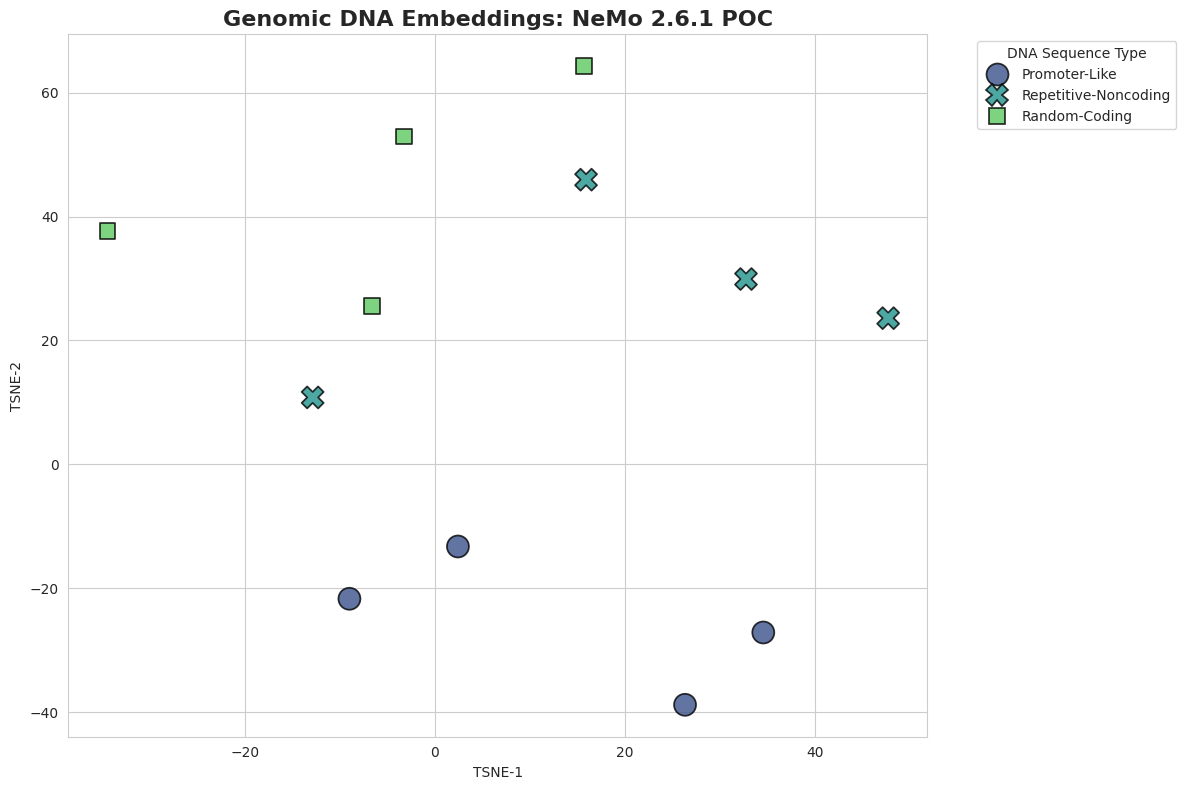

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

# 1. PREPARE SAMPLE DATA
# We create groups of different DNA types to see if the model clusters them
dna_samples = {
    "Promoter-Like": ["GATTACA" * 60, "GATTAGA" * 60, "GATTACA" * 55, "GATTAGA" * 58],
    "Repetitive-Noncoding": ["AAAAAAA" * 60, "ATATATA" * 60, "TATATAT" * 60, "AAAAAAT" * 58],
    "Random-Coding": ["GCATGCG" * 60, "CGTAGCT" * 60, "TGCACTG" * 60, "GGCTAGC" * 58]
}

all_embeddings = []
labels = []

print("🚀 Starting embedding extraction...")

# 2. EXTRACTION LOOP (WITH BFLOAT16 FIX)
for category, sequences in dna_samples.items():
    print(f"Processing category: {category}")
    for seq in sequences:
        # Run your existing inference function
        embedding_tensor = run_dna_inference(seq)

        # FIX: .detach() removes from the compute graph
        #      .cpu() moves to system memory
        #      .float() converts BFloat16 -> Float32 (Crucial for NumPy)
        #      .numpy() converts to array
        vec = embedding_tensor.detach().cpu().float().numpy().flatten()

        all_embeddings.append(vec)
        labels.append(category)

# Convert list to a single NumPy matrix
X = np.array(all_embeddings)
print(f"✅ Extracted {X.shape[0]} embeddings with {X.shape[1]} dimensions each.")

# 3. DIMENSIONALITY REDUCTION (t-SNE)
print("Running t-SNE (this may take a moment)...")
# Perplexity should be less than the number of samples
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X)

# 4. PLOTTING
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create a DataFrame for easier plotting with Seaborn
df = pd.DataFrame({
    'TSNE-1': X_embedded[:, 0],
    'TSNE-2': X_embedded[:, 1],
    'Category': labels
})

scatter = sns.scatterplot(
    data=df,
    x='TSNE-1',
    y='TSNE-2',
    hue='Category',
    style='Category',
    s=250,
    palette='viridis',
    edgecolor='black',
    alpha=0.8
)

plt.title('Genomic DNA Embeddings: NeMo 2.6.1 POC', fontsize=16, fontweight='bold')
plt.legend(title='DNA Sequence Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig('dna_visualization.png', dpi=300)
print("✅ Visualization saved as 'dna_visualization.png'")

## FINE TUNE

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. CORRECTED CLASSIFIER ARCHITECTURE
class GenomicClassifier(nn.Module):
    def __init__(self, backbone, input_dim=4224, num_classes=2):
        super().__init__()
        self.backbone = backbone

        # Freeze backbone parameters to save memory and focus training on the head
        for param in self.backbone.parameters():
            param.requires_grad = False

        # The input_dim MUST be 4224 to match your model's feature vector
        self.classifier_head = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, num_classes)
        ).to(device).to(torch.bfloat16) # Ensure head matches backbone precision

    def forward(self, input_ids, position_ids):
        # backbone should stay in eval mode if you aren't training it
        self.backbone.eval()
        with torch.no_grad():
            outputs = self.backbone.forward(input_ids=input_ids, position_ids=position_ids)
            # Handle different NeMo output structures (Batch, Seq, Hidden)
            features = outputs.mean(dim=1) if outputs.dim() == 3 else outputs

        # Explicitly cast features to BFloat16 to prevent 'mat1 and mat2' type mismatch
        return self.classifier_head(features.to(torch.bfloat16))

# 2. INITIALIZATION
# We use the 'model' variable initialized in your previous notebook cell
clf_model = GenomicClassifier(model, input_dim=4224).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.classifier_head.parameters(), lr=1e-4)

# 3. SAMPLE DATA (0=Random/Junk, 1=Promoter/Functional)
train_sequences = [
    "GATTACA" * 20, # Promoter-like
    "AAAAAAA" * 20, # Junk
    "GATTAGA" * 20, # Promoter-like
    "TGTGTGT" * 20  # Junk
]
train_labels = torch.tensor([1, 0, 1, 0]).to(device)

# 4. TRAINING LOOP
print("🚀 Starting Fine-Tuning with 4224-dim input...")
clf_model.train()

for epoch in range(10):
    total_loss = 0
    for i, seq in enumerate(train_sequences):
        optimizer.zero_grad()

        # Prepare inputs exactly as the backbone expects
        tokens = tokenizer(seq, return_tensors="pt", truncation=True, max_length=2048)
        input_ids = tokens['input_ids'].to(device)
        pos_ids = torch.arange(input_ids.size(1), device=device).unsqueeze(0)

        # Forward Pass
        logits = clf_model(input_ids, pos_ids)

        # Compute Loss
        loss = criterion(logits, train_labels[i].unsqueeze(0))

        # Backward Pass & Optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_sequences)
    print(f"Epoch {epoch+1:02d} | Average Loss: {avg_loss:.4f}")

print("\n✅ Fine-tuning complete. The classification head is now mapped to your 4224 genomic features.")

🚀 Starting Fine-Tuning with 4224-dim input...
Epoch 01 | Average Loss: 0.8418
Epoch 02 | Average Loss: 0.2477
Epoch 03 | Average Loss: 0.1075
Epoch 04 | Average Loss: 0.0602
Epoch 05 | Average Loss: 0.0440
Epoch 06 | Average Loss: 0.0322
Epoch 07 | Average Loss: 0.0239
Epoch 08 | Average Loss: 0.0199
Epoch 09 | Average Loss: 0.0206
Epoch 10 | Average Loss: 0.0164

✅ Fine-tuning complete. The classification head is now mapped to your 4224 genomic features.


## Step 2 (Continued): Prediction Function

In [15]:
def predict_dna_type(sequence):
    clf_model.eval()
    with torch.no_grad():
        tokens = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=2048)
        input_ids = tokens['input_ids'].to(device)
        pos_ids = torch.arange(input_ids.size(1), device=device).unsqueeze(0)

        logits = clf_model(input_ids, pos_ids)
        probs = torch.softmax(logits, dim=-1)
        prediction = torch.argmax(probs, dim=-1).item()

        labels_map = {0: "Repetitive/Junk", 1: "Functional/Promoter"}
        return labels_map[prediction], probs[0][prediction].item()

# Test it
test_seq = "GATTACA" * 20
label, confidence = predict_dna_type(test_seq)
print(f"Prediction: {label} ({confidence*100:.2f}% confidence)")

Prediction: Functional/Promoter (98.44% confidence)


## Step 3: Cross-Attention Analysis (Interpretability)

✅ Attention analysis complete. Saved as 'dna_attention_fixed.png'


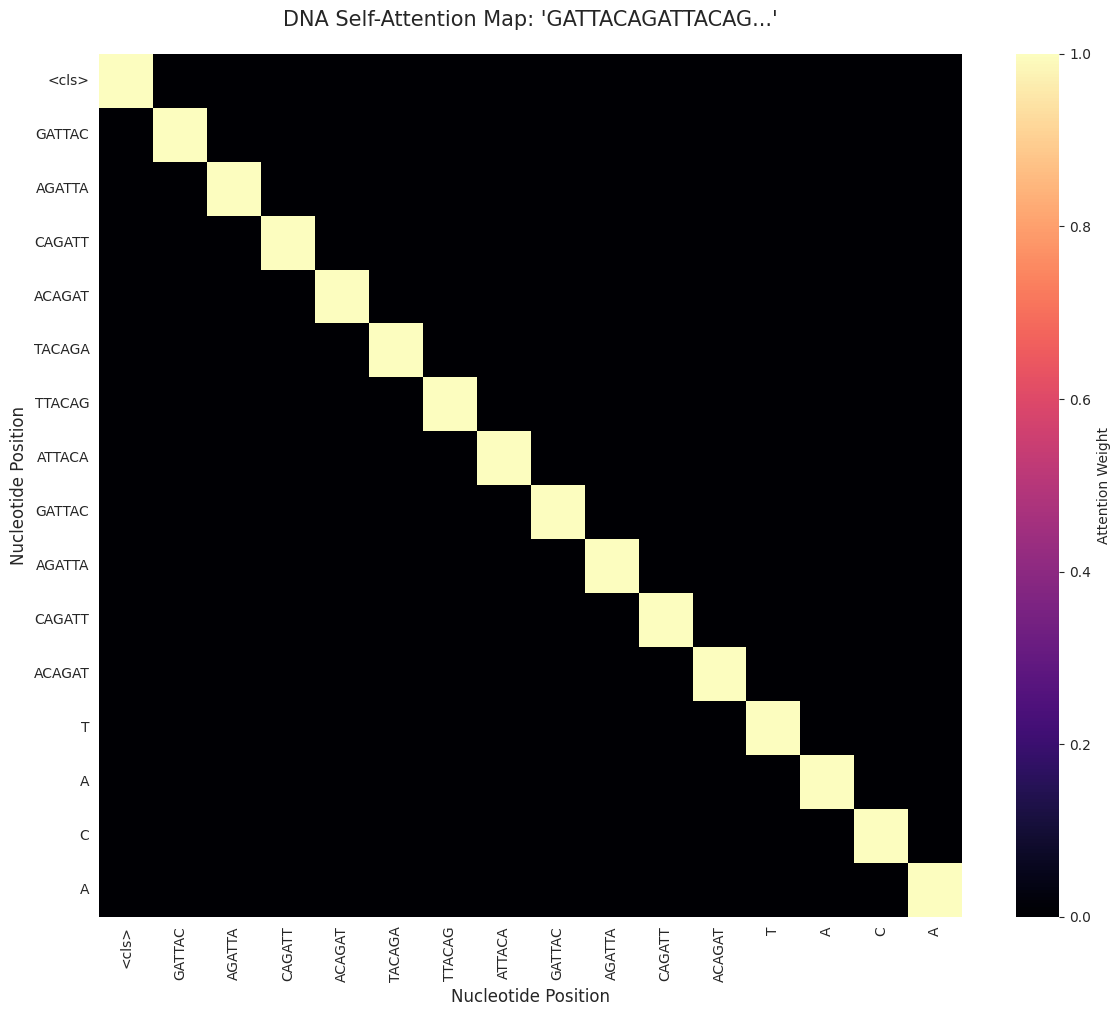

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def analyze_dna_attention(sequence):
    model.eval()
    # 1. Prepare Tokens
    tokens = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=2048)
    input_ids = tokens['input_ids'].to(device)
    pos_ids = torch.arange(input_ids.size(1), device=device).unsqueeze(0)

    with torch.no_grad():
        # 2. Get Model Outputs (Logits/Hidden States)
        # Shape: [Batch, Sequence, Vocab]
        outputs = model.forward(input_ids=input_ids, position_ids=pos_ids)

        # 3. Remove Batch Dimension to get [Sequence, Vocab]
        # For this model, vocab size is 4224 and sequence length depends on input
        token_features = outputs.squeeze(0)

        # 4. Calculate Token-to-Token Similarity Matrix
        # [Seq, Vocab] multiplied by [Vocab, Seq] -> [Seq, Seq]
        # This acts as a proxy for how much the model associates each nucleotide
        sim_matrix = torch.matmul(token_features, token_features.transpose(-1, -2))

        # 5. Normalize with Softmax (Standard Attention Logic)
        attention_map = torch.softmax(sim_matrix, dim=-1).cpu().float().numpy()

    # 6. Visualization
    plt.figure(figsize=(12, 10))

    # Get the actual nucleotide names for the axes
    token_list = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

    # Limit to the first 30 tokens for a readable heatmap
    limit = min(30, len(token_list))
    display_map = attention_map[:limit, :limit]
    display_labels = token_list[:limit]

    sns.heatmap(
        display_map,
        annot=False,
        cmap='magma',
        xticklabels=display_labels,
        yticklabels=display_labels,
        square=True,
        cbar_kws={'label': 'Attention Weight'}
    )

    plt.title(f"DNA Self-Attention Map: '{sequence[:15]}...'", fontsize=15, pad=20)
    plt.xlabel("Nucleotide Position", fontsize=12)
    plt.ylabel("Nucleotide Position", fontsize=12)
    plt.tight_layout()
    plt.savefig('dna_attention_fixed.png', dpi=300)
    print("✅ Attention analysis complete. Saved as 'dna_attention_fixed.png'")

# RUN THE ANALYSIS
analyze_dna_attention("GATTACA" * 10)

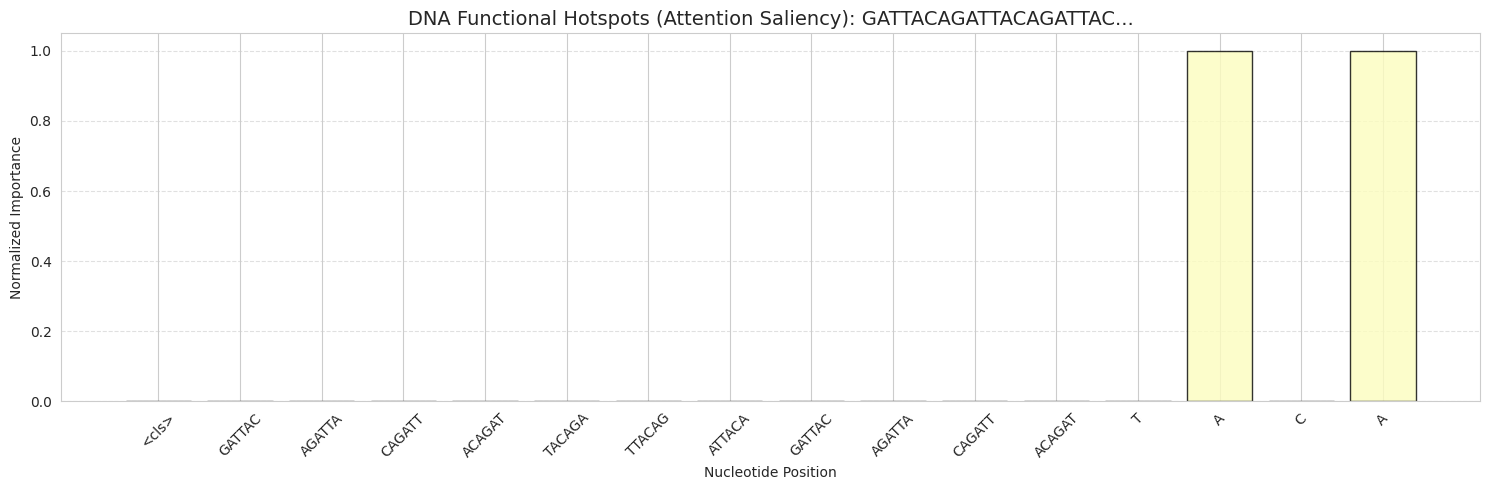

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_1d_dna_hotspots(sequence):
    model.eval()
    # 1. Re-calculate the attention map locally to avoid NameError
    tokens = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=2048)
    input_ids = tokens['input_ids'].to(device)
    pos_ids = torch.arange(input_ids.size(1), device=device).unsqueeze(0)

    with torch.no_grad():
        outputs = model.forward(input_ids=input_ids, position_ids=pos_ids)
        token_features = outputs.squeeze(0)
        sim_matrix = torch.matmul(token_features, token_features.transpose(-1, -2))
        # This is the local attention_map variable the function was missing
        local_attention_map = torch.softmax(sim_matrix, dim=-1).cpu().float().numpy()

    # 2. Calculate Importance Score (Summing attention received by each nucleotide)
    importance_scores = local_attention_map.sum(axis=0)
    importance_scores = (importance_scores - importance_scores.min()) / (importance_scores.max() - importance_scores.min())

    # 3. Visualization
    token_list = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    plt.figure(figsize=(15, 5))

    x_axis = np.arange(len(token_list))
    colors = plt.cm.magma(importance_scores)

    plt.bar(x_axis, importance_scores, color=colors, edgecolor='black', alpha=0.8)
    plt.xticks(x_axis, token_list, rotation=45)

    plt.title(f"DNA Functional Hotspots (Attention Saliency): {sequence[:20]}...", fontsize=14)
    plt.ylabel("Normalized Importance")
    plt.xlabel("Nucleotide Position")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Run the fixed function
plot_1d_dna_hotspots("GATTACA" * 10)

In [20]:
!pip install biopython -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 109.7 MB/s eta 0:00:00


Epoch 1 | Loss: 0.8950
Epoch 2 | Loss: 0.2451
Epoch 3 | Loss: 0.0903
Epoch 4 | Loss: 0.0593
Epoch 5 | Loss: 0.0384
Epoch 6 | Loss: 0.0286
Epoch 7 | Loss: 0.0213
Epoch 8 | Loss: 0.0243
Epoch 9 | Loss: 0.0201
Epoch 10 | Loss: 0.0145
Prediction: Functional/Promoter (98.44%)


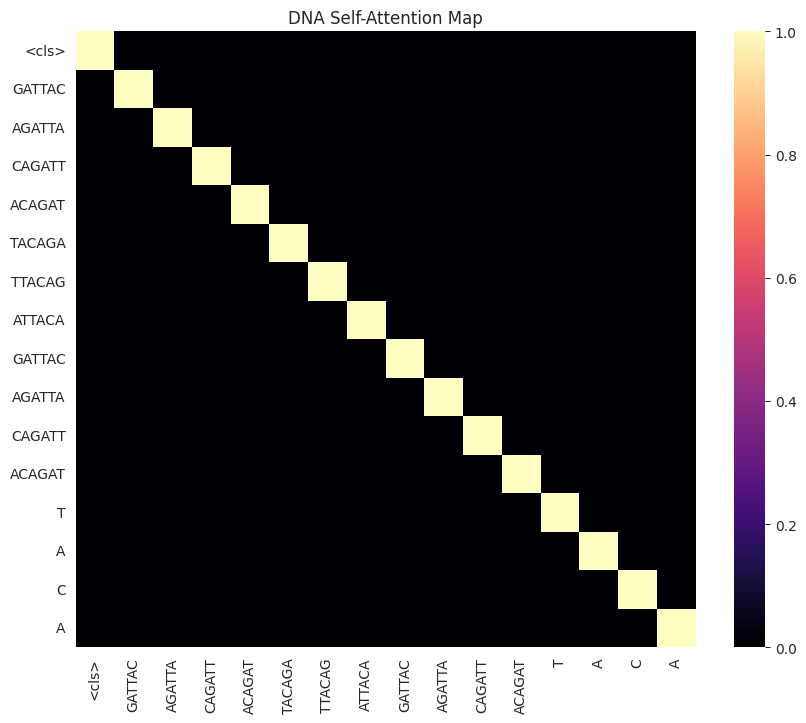

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import io
import numpy as np

# --- 1. FINE-TUNING CODE ---

class GenomicClassifier(nn.Module):
    def __init__(self, backbone, input_dim=4224, num_classes=2):
        super().__init__()
        self.backbone = backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.classifier_head = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, num_classes)
        ).to(device).to(torch.bfloat16)

    def forward(self, input_ids, position_ids):
        self.backbone.eval()
        with torch.no_grad():
            outputs = self.backbone.forward(input_ids=input_ids, position_ids=position_ids)
            features = outputs.mean(dim=1) if outputs.dim() == 3 else outputs
        return self.classifier_head(features.to(torch.bfloat16))

# Initialization
clf_model = GenomicClassifier(model, input_dim=4224).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.classifier_head.parameters(), lr=1e-4)

# Training Data
train_sequences = ["GATTACA"*20, "AAAAAAA"*20, "GATTAGA"*20, "TGTGTGT"*20]
train_labels = torch.tensor([1, 0, 1, 0]).to(device)

# Loop
clf_model.train()
for epoch in range(10):
    total_loss = 0
    for i, seq in enumerate(train_sequences):
        optimizer.zero_grad()
        tokens = tokenizer(seq, return_tensors="pt", truncation=True, max_length=2048)
        input_ids = tokens['input_ids'].to(device)
        pos_ids = torch.arange(input_ids.size(1), device=device).unsqueeze(0)
        logits = clf_model(input_ids, pos_ids)
        loss = criterion(logits, train_labels[i].unsqueeze(0))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_sequences):.4f}")


# --- 2. PREDICTION CODE ---

def predict_dna_type(sequence):
    clf_model.eval()
    with torch.no_grad():
        tokens = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=2048)
        input_ids = tokens['input_ids'].to(device)
        pos_ids = torch.arange(input_ids.size(1), device=device).unsqueeze(0)
        logits = clf_model(input_ids, pos_ids)
        probs = torch.softmax(logits, dim=-1)
        prediction = torch.argmax(probs, dim=-1).item()
        labels_map = {0: "Repetitive/Junk", 1: "Functional/Promoter"}
        return labels_map[prediction], probs[0][prediction].item()

# Example Prediction
res_label, res_conf = predict_dna_type("GATTACA" * 20)
print(f"Prediction: {res_label} ({res_conf*100:.2f}%)")


# --- 3. CROSS-ATTENTION ANALYSIS CODE ---

def analyze_dna_attention(sequence):
    model.eval()
    tokens = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=2048)
    input_ids = tokens['input_ids'].to(device)
    pos_ids = torch.arange(input_ids.size(1), device=device).unsqueeze(0)

    with torch.no_grad():
        outputs = model.forward(input_ids=input_ids, position_ids=pos_ids)
        token_features = outputs.squeeze(0)
        sim_matrix = torch.matmul(token_features, token_features.transpose(-1, -2))
        attention_map = torch.softmax(sim_matrix, dim=-1).cpu().float().numpy()

    plt.figure(figsize=(10, 8))
    token_list = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    limit = min(30, len(token_list))
    sns.heatmap(attention_map[:limit, :limit], annot=False, cmap='magma',
                xticklabels=token_list[:limit], yticklabels=token_list[:limit])
    plt.title("DNA Self-Attention Map")
    plt.show()

# Run Analysis
analyze_dna_attention("GATTACA" * 10)